# SSIM Autoencoderによる異常音検知

In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import os
import re
import pathlib
import h5py
import joblib #並列処理のためのライブラリ
import shutil
from tqdm import tqdm # for文の進捗をプログレスバーで可視化する
import matplotlib.pyplot as plt
import glob
import wave
import tensorflow as tf

from audio_processing.librosa_compute_spectrogram import wav_to_spectrogram
from utils.data_loader import return_dataset_loader

from test import test
from utils import visualization
from utils import validate

## MLflowのexperimentとRunを設定

ログが置かれたディレクトリを指定して以下のコマンドを実行(mlflowの環境下で実行)

mlflow ui --backend-store-uri /path/to/uri --port 5000

In [2]:
import mlflow
from pathlib import Path

# フォルダが存在しない場合に作成
mlruns_folder = Path('./mlruns')
mlruns_folder.mkdir(parents=True, exist_ok=True)

# trackingの絶対パスを指定
TRACKING_URI = mlruns_folder.resolve()

EXPERIMENT_NAME ="SSIM Autoencoder"

# トラッキングサーバ（バックエンド）の場所を指定
mlflow.set_tracking_uri(TRACKING_URI)

# Experimentの生成
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
        name=EXPERIMENT_NAME
    )
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id


# Runを設定
RUN_NAME = 'SSIM Autoencoder'
TAGS={
    'version':'1',
}
description='Anomaly detection by ssim autoencoder'

# RUNを実行
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME, tags=TAGS, description=description) as run:
    MLFLOW_RUN_ID = run.info.run_id
    
print("Experiment ID:", experiment_id)
print("Run ID:", MLFLOW_RUN_ID)
print("============================")

# ライフサイクルがdeletedになっているrunを削除（ストレージにrunが蓄積してしまうため）
relative_path = TRACKING_URI.relative_to(Path.cwd())
! mlflow gc --backend-store-uri $relative_path

Experiment ID: 0
Run ID: 0c0473342a6a4f6587b16f0ae6097ed8


In [3]:
# モジュールのオートリロード用のコマンド
%load_ext autoreload
%autoreload 2

In [4]:
# %load_ext tensorboard
# %tensorboard --logdir logs

訓練データのパスを定義

In [5]:
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
datas_dir = pathlib.Path('../../data/16000hz騒音データとスタートを合わせた音データ')
label_data_dir = pathlib.Path('../../data/学習データ(オリジナル)/')

all_traindata = [datas_dir/'210919_0031.wav', datas_dir/'210923_0034.wav', datas_dir/'210924_0035.wav']

print(all_traindata)

[WindowsPath('../../data/16000hz騒音データとスタートを合わせた音データ/210919_0031.wav'), WindowsPath('../../data/16000hz騒音データとスタートを合わせた音データ/210923_0034.wav'), WindowsPath('../../data/16000hz騒音データとスタートを合わせた音データ/210924_0035.wav')]


各要素をラベルのDFとするリストを定義

In [6]:
# ラベルのDFを作成
list_df_labelData =[]
for i in all_traindata:
#     label_data_name = i.split('/')[-1].replace('.wav', '.csv') 
    labelData_name = i.with_suffix('.csv').name
    labelData_file = label_data_dir/labelData_name
    df_labelData=pd.read_csv(labelData_file, skiprows=4, usecols=[1], header=None) 
    list_df_labelData.append(df_labelData)

# display(list_df_labelData[0])

パラメータ

In [7]:
# スペクトログラムのパラメータ
SR = 16000 # サンプリング周波数
DURATION = 1 # スペクトログラムの時間幅[s]
# SPEC_PARAMS = {'frame_length':2048, 'frame_step':400} # スペクトログラムのパラメータ
MEL_PAEAMS = {'sr':SR, 'n_fft':2048, 'hop_length':512, 'n_mels':128, 'fmax':SR/2, 'fmin':80} # メル尺度のパラメータ
# npy関係のファイルを出力するフォルダ
NPY_OUTPUT = '../autoencoder-anomaly-detection/data_output/npy/train'

IMAGE_SIZE = [128, 32] # resizeする際のサイズ
VAL_RATE = 0.1  # 全データに対するバリデーションデータの割合
BATCH_SIZE = 2048 # バッチサイズ
EPOCHS = 100  # エポック数

適用するデータ拡張を指定 

In [8]:
transformName = [
    'GaussianNoiseSNR',
    'PinkNoiseSNR',
    'PitchShift',
    'TimeShift',
    'VolumeShift',
]

メルスペクトログラムに変換

In [9]:
%%time
train_mean, train_std  = wav_to_spectrogram(NPY_OUTPUT,all_traindata, SR, DURATION, MEL_PAEAMS, transformName, list_df_labelData, 
                                            overwrite=False)

npy_output: ..\autoencoder-anomaly-detection\data_output\npy\train\npy_files
..\autoencoder-anomaly-detection\data_output\npy\trainが既に存在します
上書せずに終了
Wall time: 3 ms


標準化のための平均値と標準偏差を訓練データから算出。テストデータの標準化にも使用

In [10]:
print(f'平均値：{train_mean}')
print(f'標準偏差：{train_std}')

平均値：-41.470706939697266
標準偏差：10.922344207763672


データセットの定義

In [11]:
# 訓練データを訓練データとバリデーションデータに分割
list_train_npyFiles = glob.glob(f'{NPY_OUTPUT}/npy_files/*')

# list_train_npyFiles = list_train_npyFiles[:10000]


num_all_data = len(list_train_npyFiles)
print('全データ数:', num_all_data)

index_array = np.array(range(num_all_data))
np.random.shuffle(index_array)
num_train_data = int(num_all_data*(1-VAL_RATE))
idx_train_data = index_array[:num_train_data]
idx_val_data = index_array[num_train_data:]
print('全データ×(1-VAL_RATE):', num_train_data)

train_npyFiles = [list_train_npyFiles[idx] for idx in idx_train_data]
val_npyFiles = [list_train_npyFiles[idx] for idx in idx_val_data]
print('訓練データ数：',len(train_npyFiles))
print('valデータ数：',len(val_npyFiles)) 

# データセット
train_dataset = return_dataset_loader(train_npyFiles,
                                      IMAGE_SIZE,
                                      mean=train_mean, 
                                      std=train_std, 
                                      training=True, 
                                      batch_size=BATCH_SIZE)
val_dataset = return_dataset_loader(val_npyFiles, 
                                    IMAGE_SIZE,
                                    mean=train_mean, 
                                    std=train_std, 
                                    training=True, 
                                    batch_size=BATCH_SIZE)

全データ数: 170818
全データ×(1-VAL_RATE): 153736
訓練データ数： 153736
valデータ数： 17082


In [14]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_params(
        {
            "SR":SR,
            "DURATION":DURATION,
            "MEL_PAEAMS":MEL_PAEAMS,
            "IMAGE_SIZE":IMAGE_SIZE,
            "BATCH_SIZE":BATCH_SIZE,
            "EPOCHS":EPOCHS,
            "transformName":transformName,
            "train_mean":train_mean,
            "train_std":train_std,
            "Number of train data":num_all_data
        }
    )
#########################

# 訓練

In [15]:
# 実行時のスクリプトを保存
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_artifact("Anomalydetection.ipynb", artifact_path="source_code")
    mlflow.log_artifact("./model/autoencoder.py", artifact_path="source_code/model")
########################

In [16]:
# モデルの定義
from model.autoencoder import AutoEncoder

### SSIM Lossの定義

In [17]:
# ssim_loss
@tf.function
def ssim_loss(gt, y_pred, max_val=1.0):
    """
    gt:ground truth
    """
    return 1 - tf.reduce_mean(tf.image.ssim(gt, y_pred, max_val=max_val))

In [18]:
autoencoder = AutoEncoder(IMAGE_SIZE, 3)
autoencoder.compile(optimizer='adam', loss=ssim_loss, metrics=['mae'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 8, 8)          584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 4, 8)          0     

In [19]:
# チェックポイント
dir_checkpoint = f'./data_output/tf_ckpts/{MLFLOW_RUN_ID}'
checkpoint_filepath =os.path.join(dir_checkpoint,  'best_val_loss.ckpt')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# earlystopping 
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

Epoch 1/100
76/76 [==============================] - 46s 438ms/step - loss: 0.5862 - mae: 0.1357 - val_loss: 0.4888 - val_mae: 0.0530
Epoch 2/100
76/76 [==============================] - 16s 182ms/step - loss: 0.4787 - mae: 0.0488 - val_loss: 0.4613 - val_mae: 0.0434
Epoch 3/100
76/76 [==============================] - 16s 183ms/step - loss: 0.4560 - mae: 0.0423 - val_loss: 0.4477 - val_mae: 0.0413
Epoch 4/100
76/76 [==============================] - 16s 184ms/step - loss: 0.4451 - mae: 0.0412 - val_loss: 0.4411 - val_mae: 0.0417
Epoch 5/100
76/76 [==============================] - 16s 184ms/step - loss: 0.4387 - mae: 0.0410 - val_loss: 0.4363 - val_mae: 0.0404
Epoch 6/100
76/76 [==============================] - 16s 185ms/step - loss: 0.4343 - mae: 0.0404 - val_loss: 0.4329 - val_mae: 0.0407
Epoch 7/100
76/76 [==============================] - 16s 182ms/step - loss: 0.4313 - mae: 0.0403 - val_loss: 0.4301 - val_mae: 0.0402
Epoch 8/100
76/76 [==============================] - 16s 182ms

Epoch 62/100
76/76 [==============================] - 16s 184ms/step - loss: 0.3608 - mae: 0.0357 - val_loss: 0.3611 - val_mae: 0.0362
Epoch 63/100
76/76 [==============================] - 16s 182ms/step - loss: 0.3606 - mae: 0.0358 - val_loss: 0.3609 - val_mae: 0.0361
Epoch 64/100
76/76 [==============================] - 16s 183ms/step - loss: 0.3602 - mae: 0.0358 - val_loss: 0.3605 - val_mae: 0.0361
Epoch 65/100
76/76 [==============================] - 16s 184ms/step - loss: 0.3597 - mae: 0.0357 - val_loss: 0.3607 - val_mae: 0.0355
Epoch 66/100
76/76 [==============================] - 16s 183ms/step - loss: 0.3601 - mae: 0.0362 - val_loss: 0.3600 - val_mae: 0.0354
Epoch 67/100
76/76 [==============================] - 16s 182ms/step - loss: 0.3594 - mae: 0.0358 - val_loss: 0.3598 - val_mae: 0.0354
Epoch 68/100
76/76 [==============================] - 16s 183ms/step - loss: 0.3594 - mae: 0.0358 - val_loss: 0.3595 - val_mae: 0.0355
Epoch 69/100
76/76 [==============================] - 1

<AxesSubplot:>

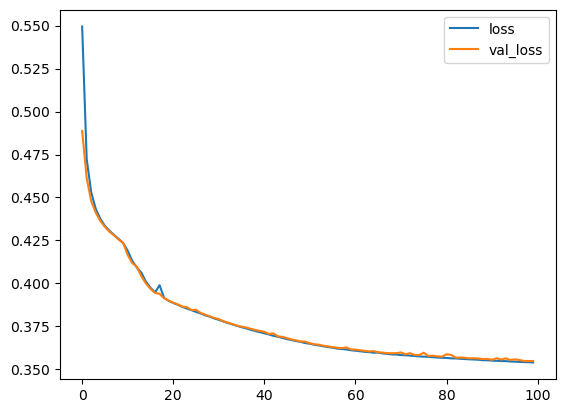

In [20]:
history = autoencoder.fit(train_dataset,  epochs=EPOCHS, validation_data=val_dataset, callbacks=[checkpoint, earlystopping])

pd.DataFrame({'loss':history.history['loss'], 'val_loss':history.history['val_loss']}).plot()    

In [21]:
######## MLflow ########################
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    # チェックポイントを保存
    mlflow.log_artifacts(dir_checkpoint, artifact_path="checkpoint")
    
    # historyを保存
    for epoch in range(EPOCHS):
        mlflow.log_metric(
            "loss", history.history["loss"][epoch], step=epoch
        )
        mlflow.log_metric(
            "val_loss", history.history["val_loss"][epoch], step=epoch
        )
        mlflow.log_metric(
            "mae", history.history["mae"][epoch], step=epoch
        )
        mlflow.log_metric(
            "val_mae",history.history["val_mae"][epoch], step=epoch,
        )

# 推論フェーズ

In [22]:
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
# テストデータ
testdata = '210921_0032'
testdata_path = [datas_dir/(testdata+'.wav')]
path_label_data = pathlib.Path('../../data/学習データ(ラベル修正)/-2109220600/-2109220600.csv')
df_test_label=pd.read_csv(path_label_data, skiprows=4, usecols=[1], header=None)  # fileをデータフレームに出力

display(df_test_label)

# 0.2秒単位のラベルをduration単位の配列に変換する
array_testlabel_data = df_test_label.iloc[:, 0].values # dfを一次元配列に変換
label_unit = validate.convert_label_unit(array_testlabel_data, duration=DURATION, list_anomalyLabel=[1, 2])

,1
0,0
1,0
2,0
3,0
4,0
...,...
287480,0
287481,0
287482,0
287483,0


テストデータをメルスペクトログラムに変換

In [23]:
# テストデータのnpyファイルの出力先
TEST_NPY_OUTPUT = f'./data_output/npy/test/{testdata}'
# テストするモデルのパス
MODEL_PATH = ''

In [24]:
%%time
_, _ = wav_to_spectrogram(TEST_NPY_OUTPUT, testdata_path, SR, DURATION, MEL_PAEAMS, overwrite=True)

npy_output: data_output\npy\test\210921_0032\npy_files


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.92it/s]


Wall time: 4min 44s


テストデータのデータセット作成

In [25]:
# npyファイルのリストを時系列順にする必要がある
def extract_number(path):
    """
    ファイル名に付与されている番号でソートするための関数
    """
    filename = pathlib.Path(path).name
    match = re.search(r'(\d+)(_.*)', filename)
    try:
        key = int(match.group(1))
        return key
    
    except Exception as e:
        print(e)

list_test_npyFiles = glob.glob(f'{TEST_NPY_OUTPUT}/npy_files/*')
list_test_npyFiles.sort(key=extract_number)  # ファイル名に付与された数字でリストをソート
# print(list_test_npyFiles)

In [26]:
num_all_test_data = len(list_test_npyFiles)
print('全データ数:', num_all_test_data)

# データセット
test_dataset = return_dataset_loader(list_test_npyFiles,
                                      IMAGE_SIZE,
                                      training=False, 
                                      mean=train_mean, 
                                      std=train_std, 
                                      batch_size=BATCH_SIZE)

# for i in test_dataset:
#     print(tf.shape(i))
#     print(i)

全データ数: 57496


### 最良モデルの読み込み

In [27]:
# 重みの読み込み
autoencoder = AutoEncoder(IMAGE_SIZE, 3)
autoencoder.load_weights(checkpoint_filepath)
autoencoder.compile(optimizer='adam', loss=ssim_loss, metrics=['mae'])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 32, 3)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 32, 16)       448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 8, 8)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 8, 8)          584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 4, 8)          0   

異常度算出

In [28]:
%%time
anomaly_score = test(autoencoder, test_dataset)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:46<00:00,  1.59s/it]

Wall time: 46 s


### 閾値の計算

訓練データに対する異常度の平均よりS×標準偏差上の値を閾値とする

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:12<00:00,  5.95it/s]

Threshold:  0.038685775334783644


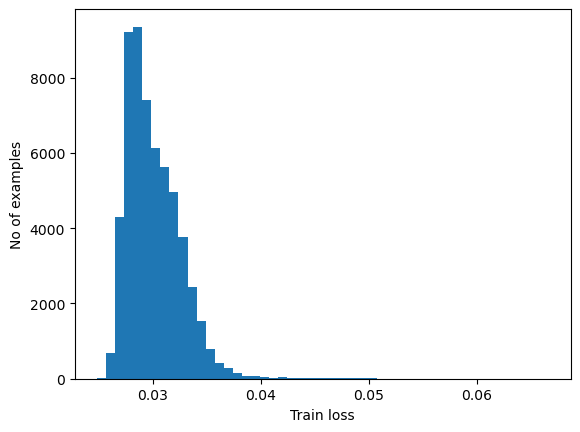

In [29]:
# 閾値の計算
S = 0.5
train_anomaly_score = test(autoencoder, train_dataset)
THRESHOLD = np.mean(train_anomaly_score) + S*np.std(train_anomaly_score)
print("Threshold: ", THRESHOLD)

plt.hist(anomaly_score, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## 評価

AU PR:0.6711036147442425


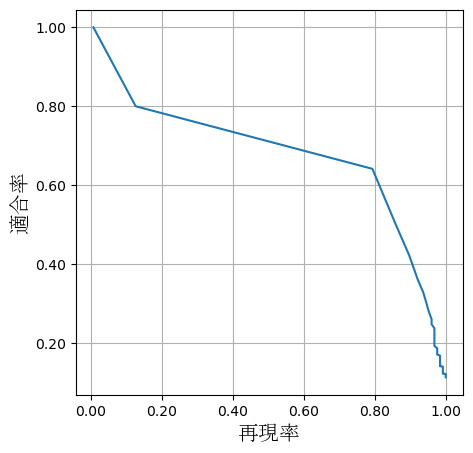

In [30]:
auPR, fig, thr_max_f_score, _  = validate.plot_PR(label_unit, anomaly_score, 100)
fig_PR = validate.plot_to_image(fig)
print(f"AU PR:{auPR}")

AU ROC:0.9815931953495913


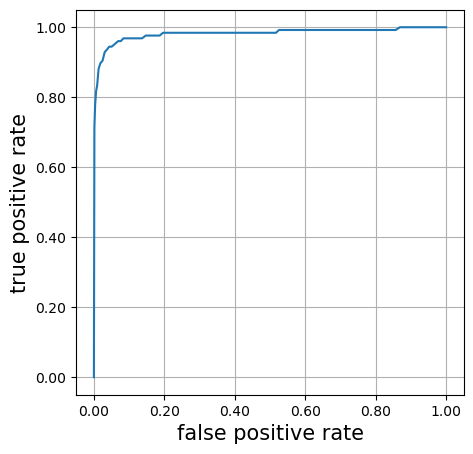

In [31]:
auROC, fig = validate.plot_ROC(label_unit, anomaly_score, 100)
fig_ROC = validate.plot_to_image(fig)
print(f"AU ROC:{auROC}")

In [32]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_metric("Threshold", THRESHOLD)
    
    mlflow.log_metric("AU PR", auPR)
    mlflow.log_metric("AU ROC", auROC)

    mlflow.log_image(fig_PR.numpy()[0], 'fig_PR.png')
    mlflow.log_image(fig_ROC.numpy()[0], 'fig_ROC.png')
########################

## 異常度可視化

In [33]:
start='2022-09-21 06:00:00'
end='2022-09-21 22:00:00'

uLimit=anomaly_score.max()

fig = visualization.plot_anomaly_score(start, end, DURATION, anomaly_score, label_unit, thr_max_f_score, uLimit)
fig_anomalyscore = visualization.plot_to_image(fig)

####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_image(fig_anomalyscore.numpy()[0], 'fig_anomalyscore.png')
########################

## 異常データの再構成画像可視化

In [34]:
def plot_spectrogram(x):
    fig, axes = plt.subplots(1, figsize=(12, 8))
    axes.imshow(x, origin='lower')
    axes.set_title('Spectrogram')
    
    return fig

npy_output: data_output\npy\abnormal\npy_files


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 988.52it/s]


Wall time: 4.48 s


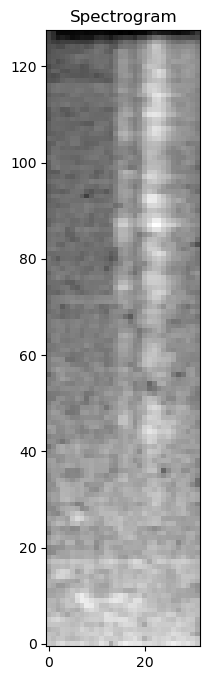

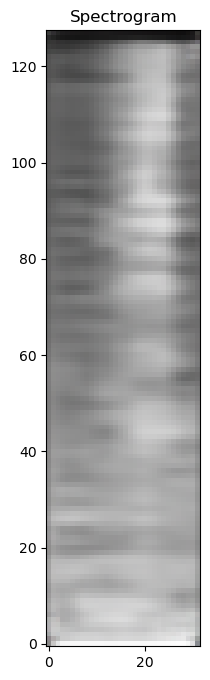

In [35]:
%%time
import tensorflow as tf

abnormal_wav = ["../../data/閾値に使用するデータ/wav_異常音/210922_0033/210922_0033_0;0;11-0;0;13.wav"]
abnormal_npy = "./data_output/npy/abnormal"

_, _ = wav_to_spectrogram(abnormal_npy, abnormal_wav, SR, DURATION, MEL_PAEAMS, overwrite=True)

list_abnormal_npyFiles = glob.glob(f'{abnormal_npy}/npy_files/*')
# データセット
abnormal_dataset = return_dataset_loader(list_abnormal_npyFiles,
                                      IMAGE_SIZE,
                                      training=False, 
                                      mean=train_mean, 
                                      std=train_std, 
                                      batch_size=BATCH_SIZE)

for batch_x, batch_y in abnormal_dataset.take(1):
    input_image = batch_x[0]
    fig = plot_spectrogram(input_image)
    image_input = visualization.plot_to_image(fig)

    batch_image = tf.expand_dims(input_image,axis=0)
    model_x = autoencoder.predict(batch_image)
    fig = plot_spectrogram(model_x[0])
    image_output = visualization.plot_to_image(fig)
    
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_image(image_input.numpy()[0], 'image_input.png')
    mlflow.log_image(image_output.numpy()[0], 'image_output.png')
########################